Get ZTF quasar data ... 

This is similar to getting the PTF quasar data  - I can upload the catalog of all S82 QSO, and get the results ... Thus I follow parts of `../code/AC_SDSS_PTF_CRTS...`


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

#https://www.ztf.caltech.edu/page/dr1


Save the ra,dec for the DR7  DBQSO  for S82 : 

In [3]:
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dr7qso = Table.read(File, format='ascii', names = colnames)

In [6]:
len(dr7qso)

9258

In [7]:
dr7qso[['dbID','ra','dec']].write('S82_QSO_9258.tbl', format='ipac')

I upload that to https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd  , 
    setting search radius to 2 arcsec 

<img src='ztf_1.png'>

5591 sources if I require  the filter to be ZTFr (rather than any filter... ). I follow this https://www.ztf.caltech.edu/page/dr1#12a  to get the light curves :
* query IRSA to get objectids matching my ra,dec


* in the results page go to Time Series Tool, click  Download Light Curve Table, as illustrated here : <img src='Lightcurve_GUI_TimeSeries_tool.jpg'>

In [181]:
ztf = Table.read('irsa_S82_ZTF_QSO_zr_5591.tbl', format='ipac')

In [182]:
ztf[:5]

cntr_01,dist_x,pang_x,dbid_01,ra_01,dec_01,oid,ra,dec,field,ccdid,qid,fid,filtercode,ngoodobs,nobs,refmag,refmagerr,astrometricrms,magrms,maxmag,medianabsdev,medianmag,minmag
,arcsec,deg,,,,,deg,deg,,,,,,,,mag,mag,deg,mag,mag,mag,mag,mag
int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,str2,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.150146,76.127197,70,2.169302,1.238649,447204300019351,2.1693425,1.238659,447,4,3,2,zr,26,27,20.532,0.049,1.247696e-06,0.2088266,20.97173,0.1503716,20.51588,20.09787
5,0.136877,-37.412038,1310,0.221552,-0.292485,396215300012732,0.2215289,-0.2924548,396,15,3,2,zr,36,36,19.724,0.027,1.385461e-06,0.1059351,20.05832,0.05920219,19.70465,19.5281
6,0.077732,42.182394,1327,0.28137,0.686984,396215200003480,0.2813845,0.687,396,15,2,2,zr,41,41,19.689,0.03,1.095131e-06,0.1235665,20.07682,0.04879761,19.66974,19.35983
7,0.063145,-61.38648,1540,2.607954,0.913245,396214200001321,2.6079386,0.9132534,396,14,2,2,zr,48,49,18.889,0.017,1.113295e-06,0.105234,19.19911,0.03849983,18.89963,18.43356
10,0.145407,-23.64489,2306,4.026021,0.478127,396213200012736,4.0260048,0.478164,396,13,2,2,zr,21,21,20.667,0.043,1.203612e-06,0.1913845,20.97645,0.1536598,20.61003,20.30641


## SDSS - ZTF Standard Stars 

Also, load the ZTF data for S82 stars to get offsets 

In [11]:
# get also the ztf data for S82 standard stars, to find out whether ZTF r is sufficiently 
# similar to SDSS r ...

s82_sub = Table.read('stripe82calibStars_100k_subset_ra_dec.txt',
                                     format='ascii')

In [13]:
s82_sub.rename_column('RA','ra')
s82_sub.rename_column('Dec','dec')
s82_sub.write('S82_stars_100k.tbl', format='ipac')

In [3]:
#Asking for only ZTF r,  I get 40963  stars within 1 arcsec.  
ztf_s = Table.read('irsa_S82_stars_40963.tbl', format='ipac')
ztf_s.rename_column('starid_01','starID')

In [4]:
# plot SDSS r against ZTF r ... 
s82 = Table.read('stripe82calibStars_100k_subset.txt', format='ascii')

In [5]:
ztf_sdss = join(ztf_s, s82, keys='starID')  

In [6]:
ztf_sdss[:5]

cntr_01,dist_x,pang_x,starID,ra_01,dec_01,oid,ra,dec,field,ccdid,qid,fid,filtercode,ngoodobs,nobs,refmag,refmagerr,astrometricrms,magrms,maxmag,medianabsdev,medianmag,minmag,d2d,col1,RA,Dec,RArms,Decrms,Ntot,Ar,uNobs,umed,ummu,umsig,umrms,umchi2,gNobs,gmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmed,rmmu,rmsig,rmrms,rmchi2,iNobs,imed,immu,imsig,imrms,imchi2,zNobs,zmed,zmmu,zmsig,zmrms,zmchi2
,arcsec,deg,,,,,deg,deg,,,,,,,,mag,mag,deg,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,str2,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
17141,0.145766,-128.489234,19,308.5223999,-1.207152,439209100007691,308.5223682,-1.2071772,439,9,1,2,zr,91,92,16.761,0.015,6.597132e-07,0.03161704,16.82633,0.0097332,16.75441,16.53501,0.0,CALIBSTARS,308.5223999,-1.207152,0.023,0.019,4,0.553,4,18.803,18.8,0.014,0.037,1.4,4,17.444,17.443,0.007,0.003,0.0,4,16.81,16.806,0.004,0.008,0.8,4,16.542,16.542,0.006,0.013,0.8,4,16.403,16.402,0.01,0.008,0.1
99667,0.128652,42.613474,64,308.5125122,-1.1041679,439209100005643,308.5125364,-1.1041416,439,9,1,2,zr,71,71,19.475,0.022,1.259215e-06,0.1452722,19.68585,0.07381821,19.4698,18.72959,--,CALIBSTARS,308.5125122,-1.1041679,0.019,0.029,4,0.524,2,22.17,22.063,0.157,0.362,2.2,4,20.409,20.418,0.014,0.03,1.3,4,19.539,19.538,0.008,0.01,0.4,4,19.214,19.205,0.01,0.03,2.2,4,18.926,18.957,0.024,0.069,2.1
17149,0.238565,71.342317,76,308.5272827,-1.2374009,439209100020583,308.5273455,-1.2373797,439,9,1,2,zr,84,85,18.978,0.019,1.135816e-06,0.08679029,19.30234,0.0364418,18.98192,18.77011,0.0,CALIBSTARS,308.5272827,-1.2374009,0.014,0.021,4,0.559,4,21.084,21.066,0.048,0.061,0.5,4,19.734,19.719,0.01,0.029,2.4,4,19.053,19.054,0.007,0.015,1.1,4,18.749,18.747,0.009,0.025,1.8,4,18.575,18.559,0.018,0.038,1.1
17124,0.129421,-15.154666,129,308.5052185,-1.0881032,439209100005332,308.5052091,-1.0880685,439,9,1,2,zr,51,51,20.081,0.035,1.738782e-06,0.180264,20.44893,0.1007576,20.13962,19.65367,0.0,CALIBSTARS,308.5052185,-1.0881032,0.008,0.032,4,0.521,0,0.047,0.047,0.0,0.0,0.0,4,21.575,21.566,0.032,0.075,1.5,4,20.252,20.25,0.013,0.019,0.5,4,19.699,19.691,0.013,0.045,3.0,4,19.289,19.3,0.03,0.071,1.4
17179,0.029782,44.504903,162,308.5557861,-1.1127189,439209100005806,308.5557919,-1.112713,439,9,1,2,zr,69,69,19.889,0.031,1.639286e-06,0.1643879,20.16628,0.08717537,19.8644,19.35218,0.0,CALIBSTARS,308.5557861,-1.1127189,0.013,0.026,4,0.512,0,0.049,0.049,0.0,0.0,0.0,4,21.509,21.501,0.031,0.069,1.0,4,20.079,20.072,0.012,0.036,2.0,4,18.911,18.918,0.009,0.023,1.4,4,18.284,18.284,0.016,0.031,0.8


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


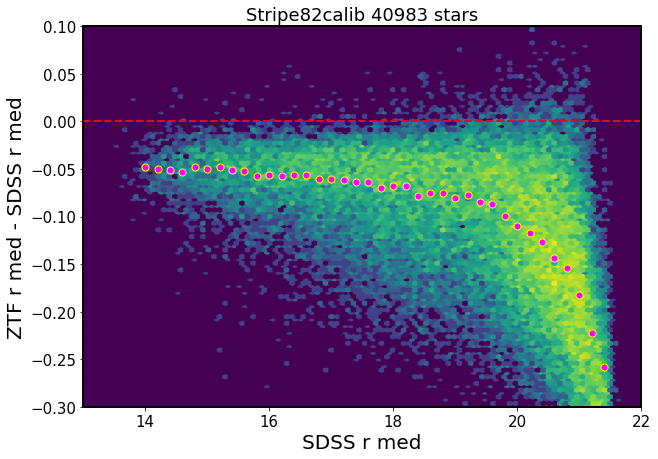

In [8]:
m = ztf_sdss['rmed'] < 22
data = ztf_sdss[m]

# check how s82 r-band compares to ps1 dr2 detections r-band - 
# could we use it without any offset  at all ?  
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(10,7))

x = data['rmed'].data
y = data['medianmag'].data - data['rmed'].data 

image = ax.hexbin(x,y,  extent=(13,22,-0.3,.1),
         bins='log')
# plot the medians too ..
xlim = ax.get_xlim()
min_x, max_x , step_size = 14,21.5, 0.2
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
#median_y_err = np.zeros(len(mean_x))
ylim = ax.get_ylim()
ymin, ymax = ylim[0],ylim[1]

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask1=  ((mean_x[j] - dx) < x) & (x<  (mean_x[j] + dx))
    mask2 =  (ymin<y)&(y<ymax)
    median_y[j] = np.median(y[mask1&mask2])
   #median_y_err[j] = np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
    # formula 3.38 , yellow book 
ax.axhline(0, lw=2,ls='--',c='r')
ax.scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow',
          s=50)
ax.set_xlabel('SDSS r med')
ax.set_ylabel('ZTF r med - SDSS r med')
#plt.colorbarimage)
ax.set_title('Stripe82calib ' + str(len(x)) + ' stars')
plt.savefig('ZTF_DR1_SDSS_Stripe82Calib.png', 
           bbox_inches='tight', dpi=100)

plot ZTF r med - SDSS r med as a function of SDSS g-i med ...   But which color t

## SDSS QSO : which colors to use  -  DR7  magnitudes vs light curve medians 

**Compare DR7  colors to medians of SDSS light curves - which ones are better to use ? **

For offsets I would use   g and i  calculated as a median of SDSS quasar light curves, because some QSO simoply don't have the colors in DBQSO (and those that are there are not exactly the same that I calculate based on light curves ... )'

What was calculated in `Combine_all_to_SDSS_r.ipynb`   , was saved in `real_outer_join_summary_SDSS.txt` - these are SDSS QSO light curve-derived averages. 
( stored in `code2/` ) 

In [96]:
summary = Table.read('real_outer_join_summary_SDSS.txt', format='ascii') 
summary['dbID'] = [int(x[:-4]) for x in summary['lcname']]

File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
sdss_dbqso = Table.read(File, format='ascii', names = colnames)

summ = join(summary, sdss_dbqso, keys='dbID')

m_bad_data = (summ['g'] < 10) & (summ['g'] > 25)
summ.remove_rows(m_bad_data)

In [102]:
mi = np.abs(summ['i']-summ['medianimag']) > 1
mg = np.abs(summ['g']-summ['mediangmag']) > 1
m = mi | mg

m =  np.abs(summ['g']-summ['mediangmag'])  < 1
np.sum(m)

9124

Show SDSS quasar light curves for which DBQSO  magnitudes are way off compared to lc-based medians. Since I would need to get the quasar  g -i color from somewhere, it would be good to check that out quickly... 

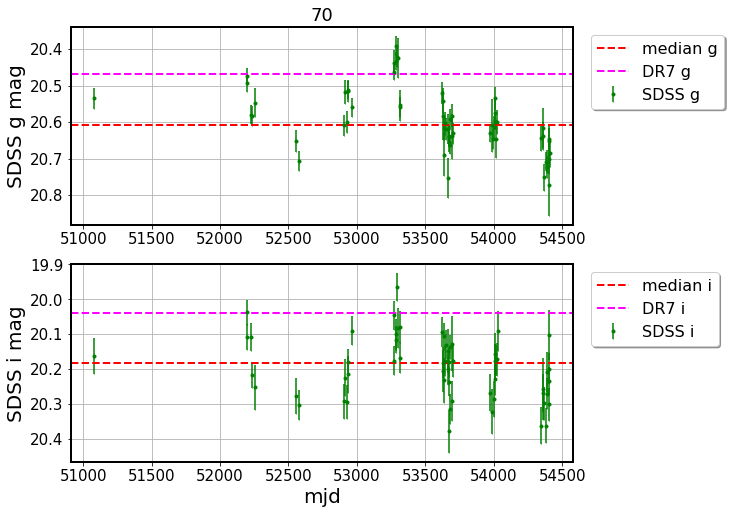

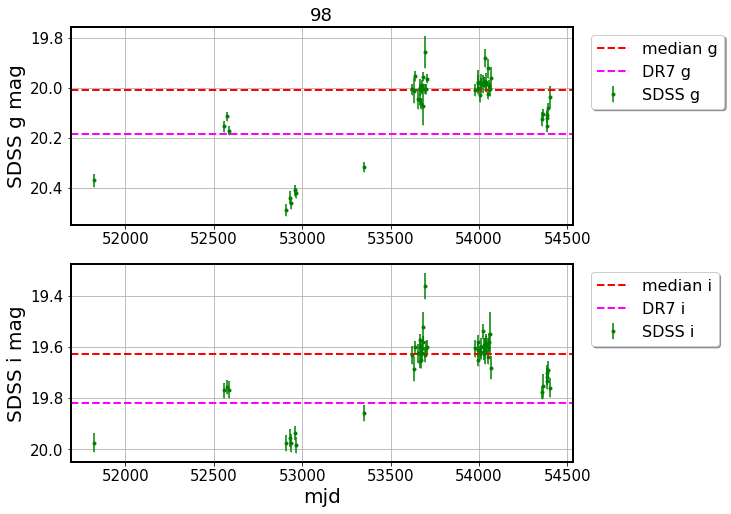

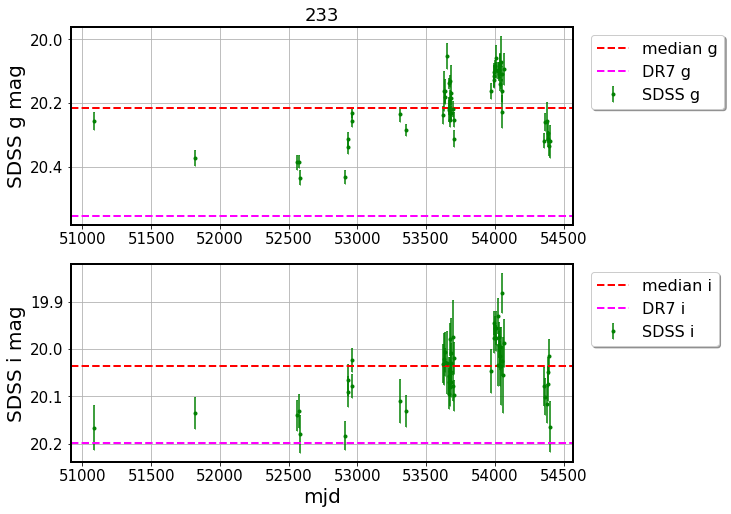

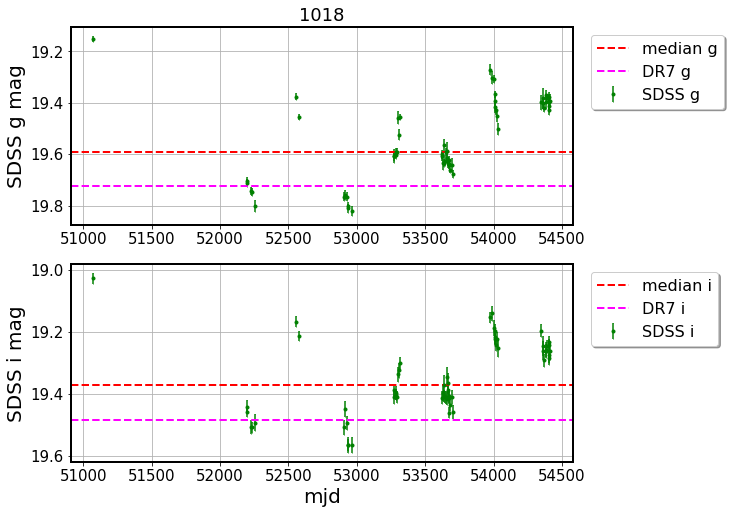

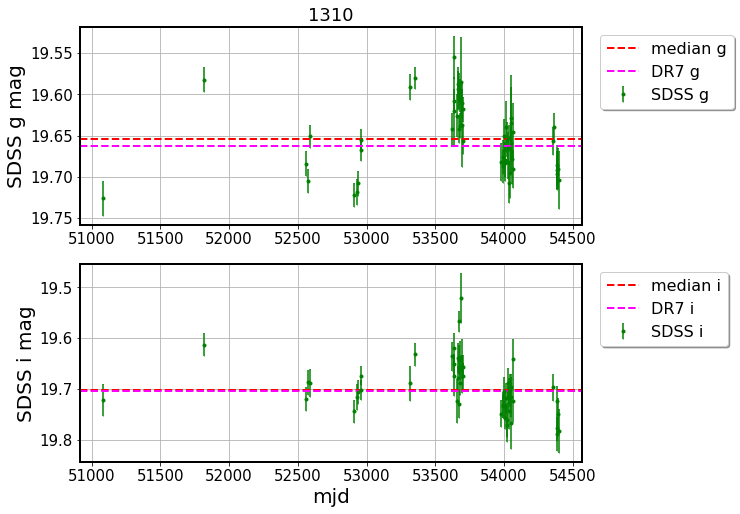

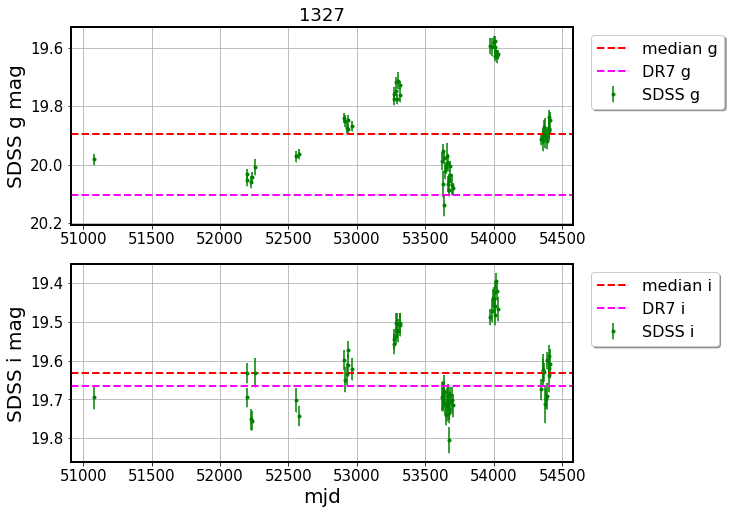

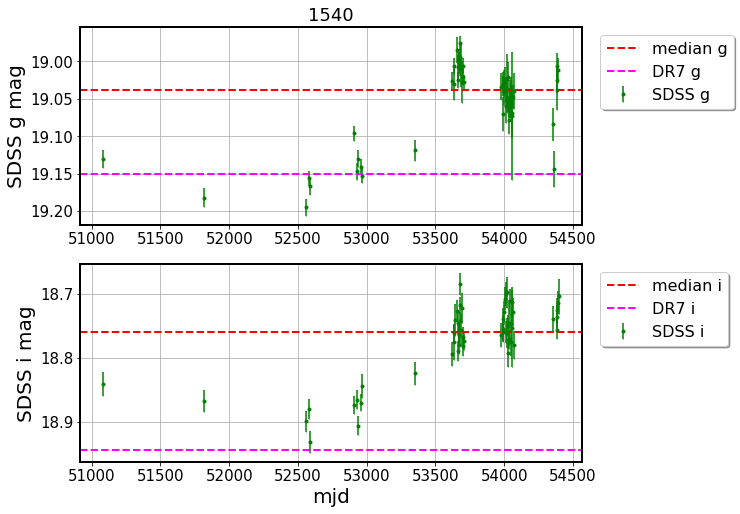

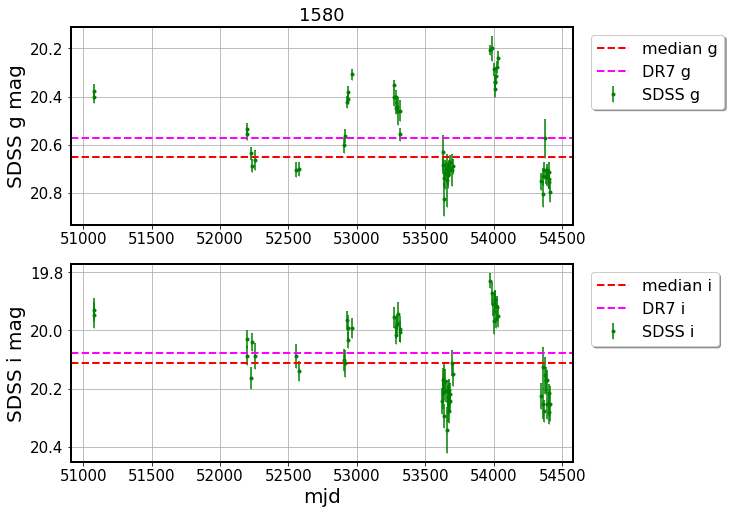

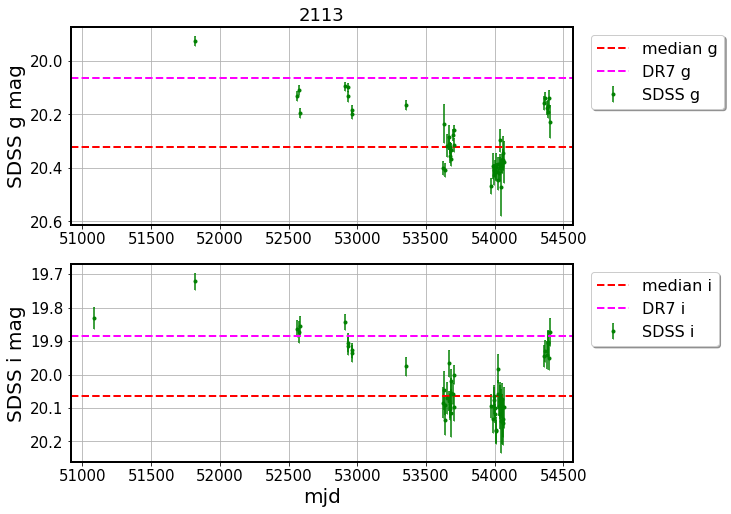

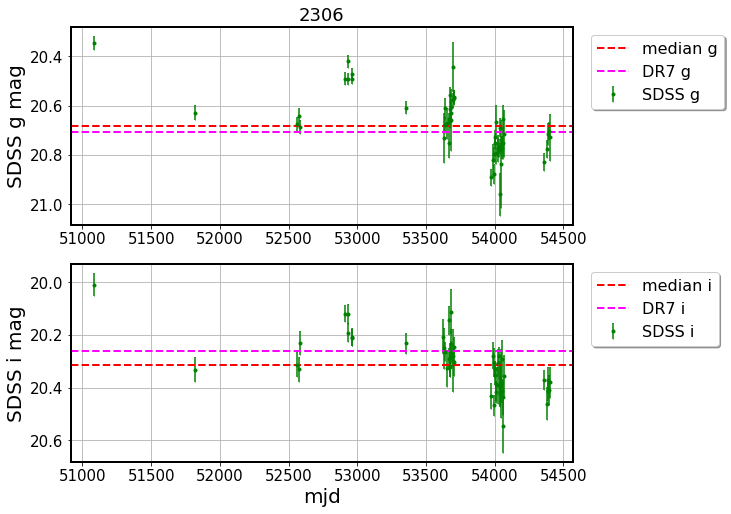

In [103]:
# SDSS colnames  : oitherwise it can;'t 
# guess the format right ... 
colnames = []
for f in 'ugriz':
    colnames.append(f+'mjd')
    colnames.append(f+ 'mag')
    colnames.append(f+'err')
colnames.append('RA')
colnames.append('DEC')


for i in range(10):#len(summ[m])):
    dbID = summ[m]['dbID'][i]
    sdss_dir = '../../CRTS_PROJECT/raw_LC_SDSS/QSO_S82/'
    lc = Table.read(sdss_dir+str(dbID), format='ascii',names=colnames)
    
    # add SDSS 
    j = 0 
    fig,ax = plt.subplots(2,1,figsize=(9,8))

    for f in 'gi':
        
        mask = (lc[f+'mag'].data > 0) & (lc[f+'mag'].data < 25)
        ax[j].errorbar(lc[f+'mjd'].data[mask], 
                   lc[f+'mag'].data[mask],
                   lc[f+'err'].data[mask],  
                    fmt=".", capsize=0.2, label='SDSS '+f,
                    c = 'green')
        
        ax[j].set_ylabel('SDSS '+f+' mag')
        ax[j].axhline(summ[m][i]['median'+f+'mag'], ls='--', 
                      lw=2,c='red', label='median '+f)
        dr7mag =  summ[m][i][f]
        if dr7mag> 0 : 
            ax[j].axhline(summ[m][i][f], ls='--', lw=2,c='magenta', label='DR7 '+f )
        ax[j].legend(loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True,fontsize=16)
        xlims = np.append(xlims, ax[j].get_xlim())
        j += 1 
        
    xlims = np.array(ax[0].get_xlim())
    xlims = np.append(xlims, ax[1].get_xlim())
    xmin,xmax = min(xlims), max(xlims)

    for j in range(len(ax)):
        ax[j].set_xlim(xmin,xmax)
        ax[j].grid()
        ax[j].invert_yaxis()
    ax[1].set_xlabel('mjd')
    ax[0].set_title(dbID)
    

Ok, so from inspecting the actual SDSS light curves, I see that DBQSO does not always get its magnitudes right -  calculating  lightcurve - based median is a way better idea... 

That's why I already used the `mediangmag  - medianimag`  in `Combine_all_to_SDSS_r.ipynb`

Plot the distribution of real quasar  g-i  ( light curve based medians ... ) : 

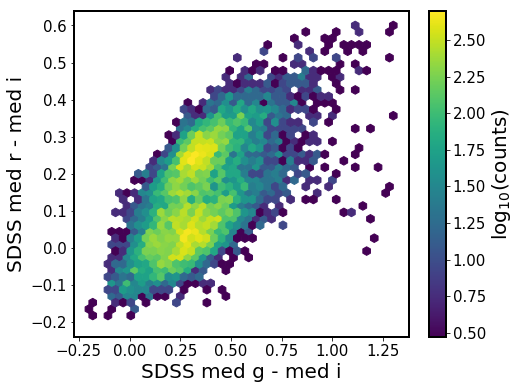

In [201]:
fig,ax = plt.subplots(1,1,figsize=(7.5,6))
x = summary['mediangmag'].data  - summary['medianimag'].data
y = summary['medianrmag'].data  - summary['medianimag'].data

iamge = ax.hexbin(x,y,extent=  (-0.2,1.3, -0.2,0.6), mincnt=2,
                 bins = 'log', gridsize=40)
ax.set_xlabel('SDSS med g - med i')
ax.set_ylabel('SDSS med r - med i')
plt.colorbar(image, label=r'$\log_{10}{(\mathrm{counts})}$')

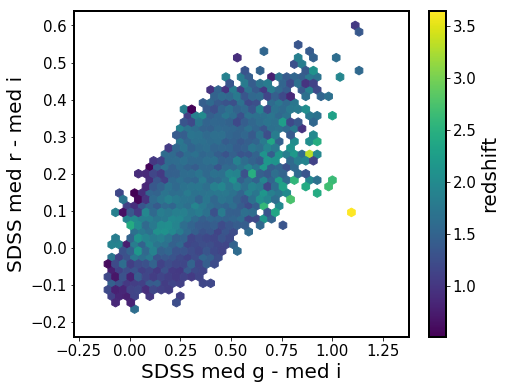

In [204]:
fig,ax = plt.subplots(1,1,figsize=(7.5,6))
x = summ['mediangmag'].data  - summ['medianimag'].data
y = summ['medianrmag'].data  - summ['medianimag'].data
z = summ['redshift'].data
image = ax.hexbin(x,y,z,extent=  (-0.2,1.3, -0.2,0.6), mincnt=2,
                  gridsize=40)
ax.set_xlabel('SDSS med g - med i')
ax.set_ylabel('SDSS med r - med i')
plt.colorbar(image, label='redshift')

Interesting -  I wonder what's the bimodal distribution about. As one can see, it's not due to redshift ... 

Show the difference between DR7 gmag and  SDSS lightcurve-based median (which is better choice than mean because it is not sensitive to the outliers ) : 

Text(0.5, 1.0, '9235 S82 QSO')

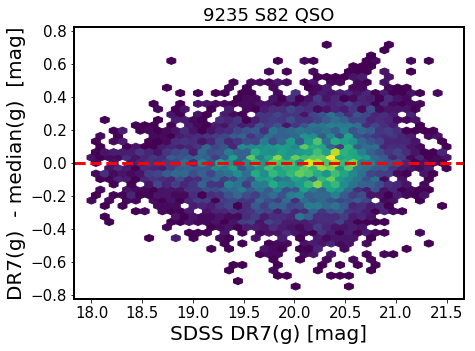

In [143]:
f = 'g'
m = (summ[f] > 0) & (summ[f] < 25) 
y = summ[f]  - summ['median'+f+'mag']
x = summ[f]
fig,ax  = plt.subplots(1,1,figsize=(7,5))
ax.hexbin(x[m],y[m], mincnt=2, extent=(18,21.5,-.75,.75), gridsize=40 )
ax.axhline(0, ls='--', lw=3, c='r')
ax.set_xlabel('SDSS DR7('+f+') [mag]')
ax.set_ylabel('DR7('+f+')  - median('+f+')  [mag]')
ax.set_title(str(np.sum(m))+' S82 QSO' )

Text(0.5, 1.0, '9235 S82 QSO')

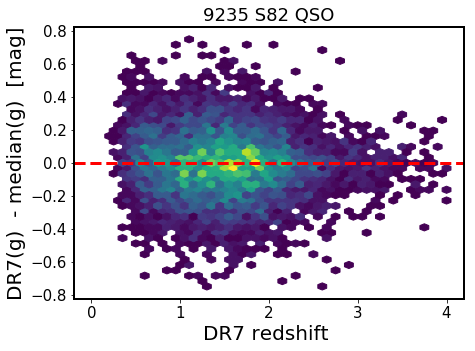

In [138]:
f = 'g'
m = (summ[f] > 0) & (summ[f] < 25) 
y = summ[f]  - summ['median'+f+'mag']
x = summ['redshift']
fig,ax  = plt.subplots(1,1,figsize=(7,5))
ax.hexbin(x[m],y[m], mincnt=2, extent = (0,4,-.75,.75), gridsize=40 )
ax.axhline(0, ls='--', lw=3, c='r')
ax.set_xlabel('DR7 redshift ')
ax.set_ylabel('DR7('+f+')  - median('+f+')  [mag]')
ax.set_title(str(np.sum(m))+' S82 QSO' )

Get the mean values for PS1 DR2 r-band : 

In [160]:
ps1dir=  '../dp2/real_sdss_ps1r_dr2_cleaned/'
lcnames = os.listdir(ps1dir)
ps1_summ  = {'lcname':np.zeros_like(lcnames, dtype='<U11'),
             'N':np.zeros_like(lcnames, dtype=int),
              'medrmag':np.zeros_like(lcnames, dtype=float)}
i = 0 
for lcname in lcnames :
    lc = Table.read(ps1dir+lcname, format='ascii')
    m = lc['survey'] == 'ps1'
    ps1_summ['lcname'][i] = lcname
    ps1_summ['N'][i] = np.sum(m)
    ps1_summ['medrmag'][i] = np.median(lc[m]['mag'])
    i += 1 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3115: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [161]:
ps1_table = Table(data=[ps1_summ['lcname'], ps1_summ['N'], ps1_summ['medrmag']],
                 names = ['lcname', 'Nps1', 'medp1rmag'])

In [164]:
summ_p1 = join(summ, ps1_table, keys='lcname')

Text(0.5, 1.0, 'S82 QSO')

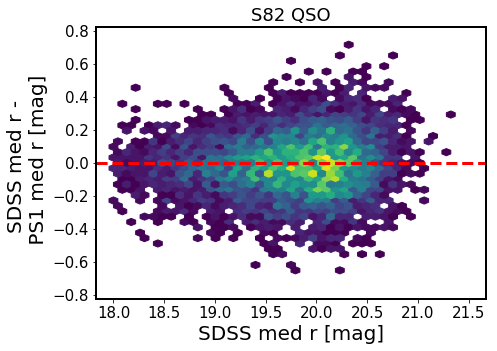

In [176]:
f = 'r'
#m = (summ_p1[f] > 0) & (summ_p1[f] < 25) 
y = summ_p1['median'+f+'mag'] - summ_p1['medp1rmag']
x = summ_p1['median'+f+'mag']
fig,ax  = plt.subplots(1,1,figsize=(7,5))
ax.hexbin(x,y, mincnt=2, extent=(18,21.5,-.75,.75), gridsize=40 )
ax.axhline(0, ls='--', lw=3, c='r')
ax.set_xlabel('SDSS med r [mag]')
ax.set_ylabel('SDSS med r - \n PS1 med r [mag]')
#ax.set_title(str(np.sum(m))+' S82 QSO' )
ax.set_title('S82 QSO')

Text(0.5, 1.0, 'S82 QSO')

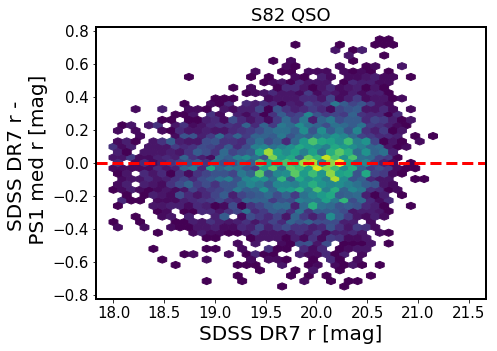

In [177]:
f = 'r'
#m = (summ_p1[f] > 0) & (summ_p1[f] < 25) 
y = summ_p1[f] - summ_p1['medp1rmag']
x = summ_p1[f]
fig,ax  = plt.subplots(1,1,figsize=(7,5))
ax.hexbin(x,y, mincnt=2, extent=(18,21.5,-.75,.75), gridsize=40 )
ax.axhline(0, ls='--', lw=3, c='r')
ax.set_xlabel('SDSS DR7 r [mag]')
ax.set_ylabel('SDSS DR7 r - \n PS1 med r [mag]')
ax.set_title('S82 QSO')

Use the median since I trust it more ... 

Text(0.5, 1.0, 'S82 QSO')

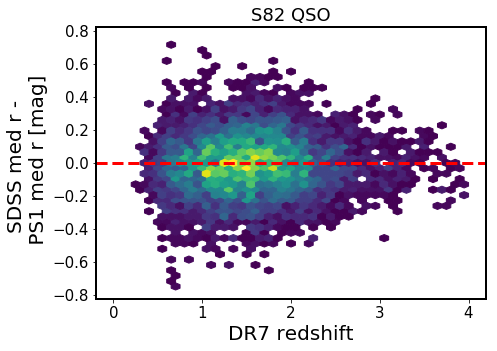

In [179]:
f = 'r'
#m = (summ_p1[f] > 0) & (summ_p1[f] < 25) 
y = summ_p1['median'+f+'mag'] - summ_p1['medp1rmag']
x = summ_p1['redshift']
fig,ax  = plt.subplots(1,1,figsize=(7,5))
ax.hexbin(x,y, mincnt=2, extent=(0,4,-.75,.75), gridsize=40 )
ax.axhline(0, ls='--', lw=3, c='r')
ax.set_xlabel('DR7 redshift')
ax.set_ylabel('SDSS med r - \n PS1 med r [mag]')
#ax.set_title(str(np.sum(m))+' S82 QSO' )
ax.set_title('S82 QSO')

15 16


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


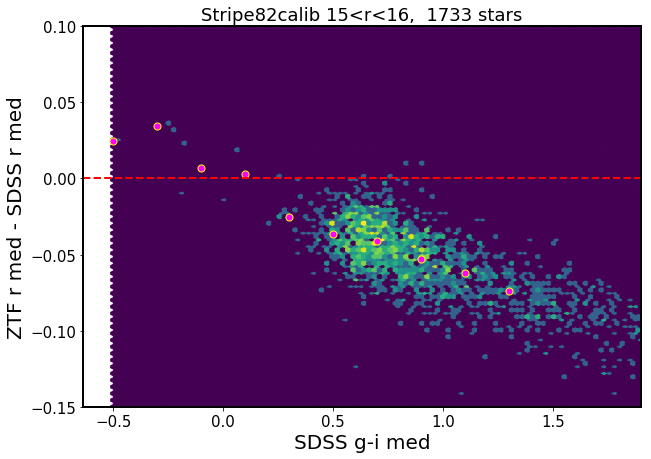

Saved as  ZTF_DR1_SDSS_Stripe82Calib_gi_15-16.png
16 17


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.


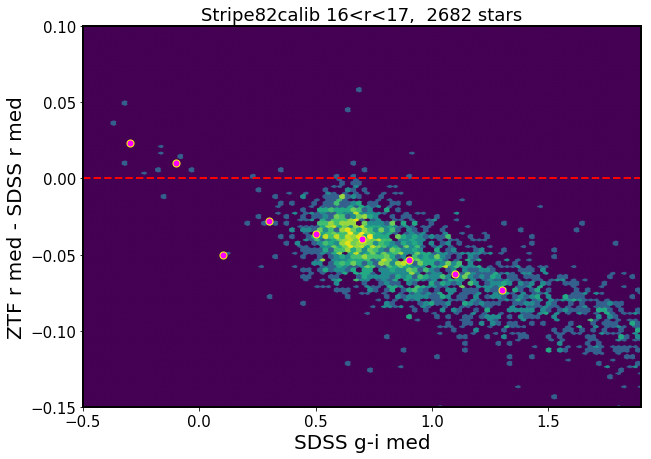

Saved as  ZTF_DR1_SDSS_Stripe82Calib_gi_16-17.png
17 18


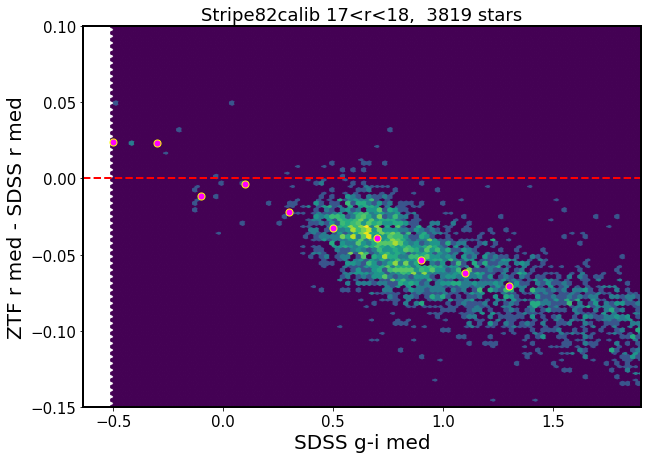

Saved as  ZTF_DR1_SDSS_Stripe82Calib_gi_17-18.png
18 19


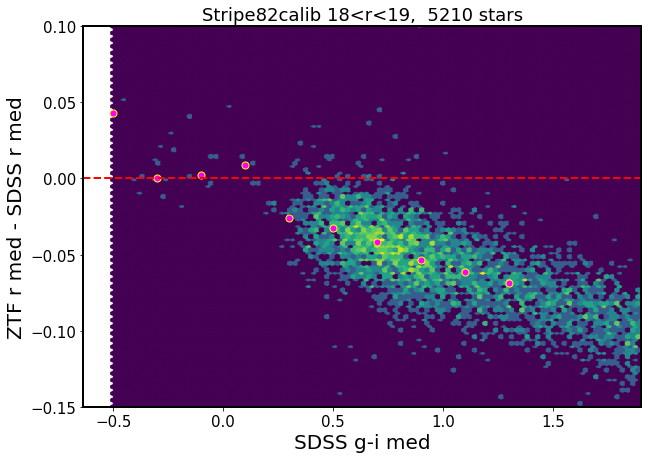

Saved as  ZTF_DR1_SDSS_Stripe82Calib_gi_18-19.png
19 20


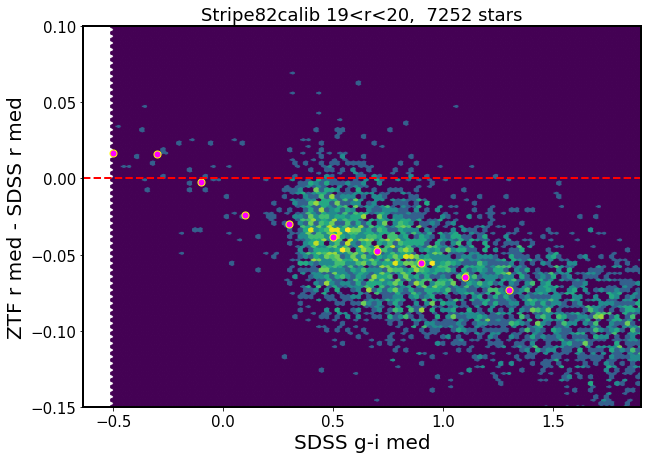

Saved as  ZTF_DR1_SDSS_Stripe82Calib_gi_19-20.png
20 21


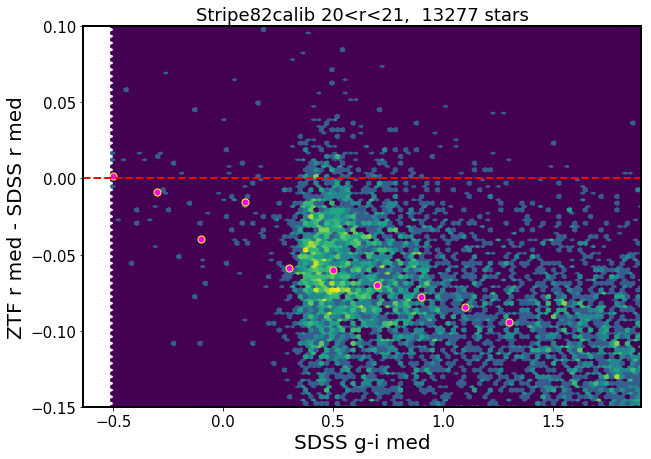

Saved as  ZTF_DR1_SDSS_Stripe82Calib_gi_20-21.png
21 22


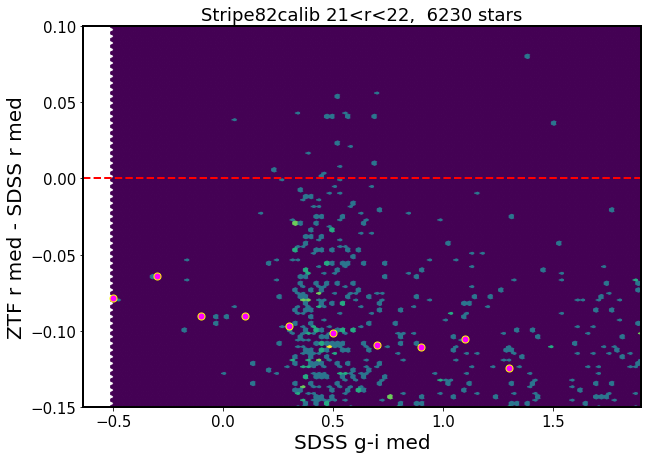

Saved as  ZTF_DR1_SDSS_Stripe82Calib_gi_21-22.png


In [183]:
for rmin in np.arange(15,22):
    rmax = rmin+1
    print(rmin, rmax)
    m =(rmin<ztf_sdss['rmed']) &  (ztf_sdss['rmed'] <rmax)
    data = ztf_sdss[m]

    # check how s82 r-band compares to ps1 dr2 detections r-band - 
    # could we use it without any offset  at all ?  
    %matplotlib inline
    fig,ax = plt.subplots(1,1,figsize=(10,7))

    x = data['gmed'].data-data['imed'].data
    y = data['medianmag'].data - data['rmed'].data 
    #extent=(13,22,-0.3,.1)
    image = ax.hexbin(x,y, extent = (-0.5,1.9,-0.15,.1
                                    ) ,
             bins='log')
    # plot the medians too ..
    xlim = ax.get_xlim()
    min_x, max_x , step_size = -0.5,1.5, 0.2
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))
    #median_y_err = np.zeros(len(mean_x))
    ylim = ax.get_ylim()
    ymin, ymax = ylim[0],ylim[1]

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask1=  ((mean_x[j] - dx) < x) & (x<  (mean_x[j] + dx))
        mask2 =  (ymin<y)&(y<ymax)
        median_y[j] = np.median(y[mask1&mask2])
       #median_y_err[j] = np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
        # formula 3.38 , yellow book 
    ax.axhline(0, lw=2,ls='--',c='r')
    ax.scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow',
              s=50)
    ax.set_xlabel('SDSS g-i med')
    ax.set_ylabel('ZTF r med - SDSS r med')
    #plt.colorbarimage)
    ax.set_title('Stripe82calib ' + str(rmin)+'<r<'+str(rmax)+\
                 ',  '+str(len(x)) + ' stars')
    figname = 'ZTF_DR1_SDSS_Stripe82Calib_gi_'+str(rmin)+'-'+str(rmax)+'.png'
    plt.savefig(figname, 
               bbox_inches='tight', dpi=100)
    plt.show()
    print('Saved as ', figname)

As one can see  - it isn't. Even ZTF r would require transformation to SDSS r... And it gets worse and worse for fainter sources. 

Check what epochs are available for ZTF objects....  - From 